In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
import random
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
import tensorflow

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/SEM 7/Specs Prj/Project

/content/drive/My Drive/SEM 7/Specs Prj/Project


In [ ]:
path = "./Key Frames(Final)/"

In [ ]:
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [ ]:
def load_data(dir,uniqueLabels, size):
    images = []
    labels = []
    #size = 32,32
    for idx, label in enumerate(uniqueLabels):
        for file in tqdm(os.listdir(dir  +"/" + label)):
          filepath = dir + "/" + label + "/" + file
          image = cv2.resize(cv2.imread(filepath), size)
          images.append(image)
          labels.append(idx)
        print(label)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [ ]:
classes = ['Violence','Non Violence']

In [ ]:
X_train, Y_train = load_data(path+"train/", classes, (75,75))

100%|██████████| 9375/9375 [02:47<00:00, 56.05it/s] 


Violence


100%|██████████| 9360/9360 [02:34<00:00, 60.66it/s] 


Non Violence


In [ ]:
X_test, Y_test = load_data(path + "test/", classes, (75,75))

100%|██████████| 4884/4884 [01:41<00:00, 47.94it/s]


Violence


100%|██████████| 4858/4858 [01:07<00:00, 71.67it/s] 


Non Violence


In [ ]:
X_eval, Y_eval = load_data(path + "val/", classes, (75,75))

100%|██████████| 1673/1673 [00:31<00:00, 53.90it/s] 


Violence


100%|██████████| 991/991 [00:12<00:00, 82.19it/s] 


Non Violence


In [ ]:
Y_trainOE = tensorflow.keras.utils.to_categorical(Y_train)
Y_testOE = tensorflow.keras.utils.to_categorical(Y_test)
Y_evalOE = tensorflow.keras.utils.to_categorical(Y_eval)
X_trainScaled = X_train.astype('float32')/255.0
X_testScaled = X_test.astype('float32')/255.0
X_evalScaled = X_eval.astype('float32')/255.0

#Defining the model

In [ ]:
from keras.layers import LSTM, Dense, Dropout, Activation, Input, Flatten, Input
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling2D, Conv2D, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling2D

In [ ]:
verbose, epochs, batch_size = True, 5, 64
n_steps, n_length = 75, 75
n_signals = 3

In [ ]:
X_trainScaled2 = X_trainScaled.reshape((X_trainScaled.shape[0], n_steps, n_length, 3))
X_evalScaled2 = X_evalScaled.reshape((X_evalScaled.shape[0],n_steps, n_length, 3))

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(32, kernel_size = 3),input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(32, kernel_size = 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation("relu")))
model.add(MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = "same"))
model.add(TimeDistributed(Dropout(0.2)))


model.add(TimeDistributed(Conv1D(64, kernel_size = 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation("relu")))
model.add(MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = "same"))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, dropout = 0.2))
model.add(Dense(128, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 73, 32)     320       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 71, 32)     3104      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 71, 32)     128       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 71, 32)     0         
 tributed)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, 71, 32)     0

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_trainScaled2, Y_trainOE, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data = (X_evalScaled2, Y_evalOE))

Epoch 1/5
293/293 [==============================] - 45s 113ms/step - loss: 0.1175 - accuracy: 0.9439 - val_loss: 0.0542 - val_accuracy: 0.9850
Epoch 2/5
293/293 [==============================] - 33s 111ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0122 - val_accuracy: 0.9959
Epoch 3/5
293/293 [==============================] - 34s 115ms/step - loss: 6.7999e-04 - accuracy: 0.9999 - val_loss: 0.0097 - val_accuracy: 0.9959
Epoch 4/5
293/293 [==============================] - 34s 116ms/step - loss: 4.6196e-04 - accuracy: 0.9999 - val_loss: 1.6291e-04 - val_accuracy: 1.0000
Epoch 5/5
293/293 [==============================] - 34s 116ms/step - loss: 2.2313e-05 - accuracy: 1.0000 - val_loss: 5.3157e-05 - val_accuracy: 1.0000


In [ ]:
modelSavePath = "./SavedModels/"
model.save(modelSavePath+"CNN+LSTM")

#Testing the model

In [ ]:
X_testScaled2 = X_testScaled.reshape((X_testScaled.shape[0], n_steps, n_length, 3))

305/305 [==============================] - 6s 19ms/step - loss: 4.6036e-05 - accuracy: 1.0000
Test accuracy: 1.0
Test loss: 4.603596607921645e-05


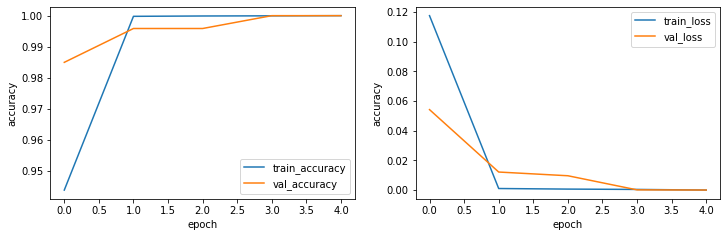

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
test_loss, test_acc = model.evaluate( X_testScaled2, Y_testOE)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (15, 15))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

153/153 [==============================] - 5s 32ms/step


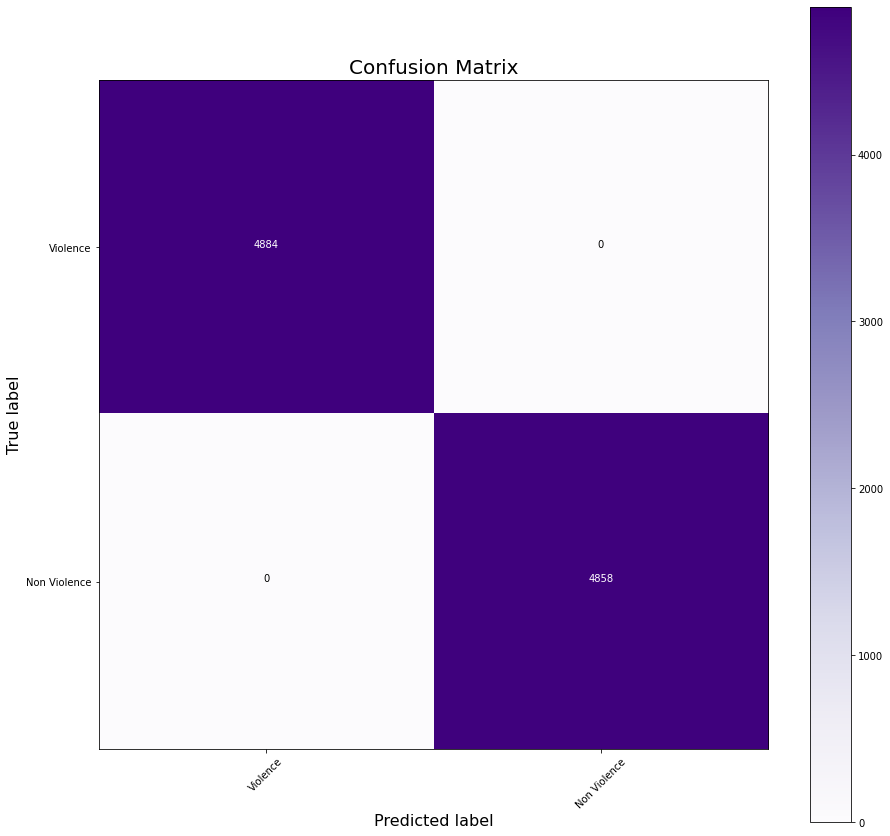

In [ ]:
y_test_pred2 = model.predict(X_testScaled2, batch_size = batch_size, verbose = verbose)
plot_confusion_matrix(Y_testOE, y_test_pred2)

In [ ]:
input_shape = (18735,65,64,3)

In [ ]:
input = Input(shape = input_shape[1:])

#model = Sequential()
y = TimeDistributed(Conv2D(32, kernel_size = (3,3),strides = (1,1), padding = "same"))(input)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation("relu"))(y)
y = MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = "same")(y)
y = TimeDistributed(Dropout(0.2))(y)

y = TimeDistributed(Conv2D(64, kernel_size = (3,3),strides = (1,1), padding = "same"))(y)
y = TimeDistributed(BatchNormalization())(y)
y = TimeDistributed(Activation("relu"))(y)
y = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same")(y)
y = TimeDistributed(Dropout(0.2))(y)

"""model.add(TimeDistributed(Conv2D(256, kernel_size = (3,3),strides = (1,1), padding = "same")))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation("relu")))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same"))
model.add(TimeDistributed(Dropout(0.2)))"""

y = TimeDistributed(Flatten())(y)

y = LSTM(256, dropout = 0.2)(y)
y = Dense(2, activation = "softmax")(y)


model = Model(inputs = input, outputs = y)

ValueError: ignored

In [ ]:
model.build(input_shape = (18735, 30, 64,64,3))

In [ ]:
model.compile(optimizer = "adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_trainScaled, Y_trainOE, batch_size = 64, epochs = 10, validation_data = (X_evalScaled, Y_evalOE) )

Epoch 1/10


ValueError: ignored

#2


In [ ]:
verbose, epochs, batch_size = True, 15, 16
n_steps, n_length = 64, 64
n_signals = 3
X_trainScaled2 = X_trainScaled.reshape((X_trainScaled.shape[0], n_steps, n_length, 3))

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_trainScaled2, Y_trainOE, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
 111/1171 [=>............................] - ETA: 8:22 - loss: 0.6622 - accuracy: 0.5946

KeyboardInterrupt: ignored